<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Logistic-regression-on-the-MNIST-dataset" data-toc-modified-id="Logistic-regression-on-the-MNIST-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Logistic regression on the MNIST dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Displaying-samples-of-the-MNIST-dataset" data-toc-modified-id="Displaying-samples-of-the-MNIST-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Displaying samples of the MNIST dataset</a></span></li></ul></li><li><span><a href="#Multiclass-Classification" data-toc-modified-id="Multiclass-Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Multiclass Classification</a></span><ul class="toc-item"><li><span><a href="#One-vs-All-classification" data-toc-modified-id="One-vs-All-classification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>One vs All classification</a></span></li><li><span><a href="#One-vs-all-Prediction" data-toc-modified-id="One-vs-all-Prediction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>One-vs-all Prediction</a></span></li></ul></li><li><span><a href="#Implementation-using-SKlearn" data-toc-modified-id="Implementation-using-SKlearn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation using SKlearn</a></span></li></ul></div>

# Logistic regression on the MNIST dataset
This notebook explores a Python implementation of logistic regression on the MNIST dataset 

These are Python implementations of exercise 3) from Andrew Ng's course: Machine Learning on coursera.

Some similar notebooks and sources: 
[1][1] 
[2][2] 
[3][3]

### Libraries

[1]: http://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%203%20-%20Multi-class%20Classification%20and%20Neural%20Networks.ipynb

[2]: https://github.com/kaleko/CourseraML/blob/a815ac95ba3d863b7531926b1edcdb4f5dd0eb6b/ex3/ex3.ipynb

[3]: https://github.com/nex3z/machine-learning-exercise/blob/master/coursera-machine-learning-python/ex3/ex3.ipynb

In [1]:
import math as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import scipy.optimize as opt
from sklearn import linear_model
%matplotlib inline
sns.set(style='white')
sns.set_context('notebook')

## Dataset
The initial dataset is a subset of the MNIST handwritten dataset provided by Andrew Ng's Coursera ML course. It contains 5000 training examples of handwritten digits, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

### Load the data from matlab format into numpy format 



In [2]:
mat_data = sio.loadmat('/Users/User/Desktop/Computer_Science/stanford_ml/machine-learning-ex3/ex3/ex3data1.mat')
sio.whosmat('/Users/User/Desktop/Computer_Science/stanford_ml/machine-learning-ex3/ex3/ex3data1.mat')
X = mat_data['X']
y =  mat_data['y']
#np.place(y,y==10,0) #Replace value 10 with value 0 (due to Octave non zero indexing..)
display(X.shape)
display(y.shape)
m , n = X.shape

(5000, 400)

(5000, 1)

## Displaying samples of the MNIST dataset
We will explore in this section various ways of displaying the MNIST dataset. Note that each row corresponds to a digit, and to display a digit we must reshape the row into a 20 x 20 matrix and transpose the result

### Using Matplotlib .imshow() and subplots

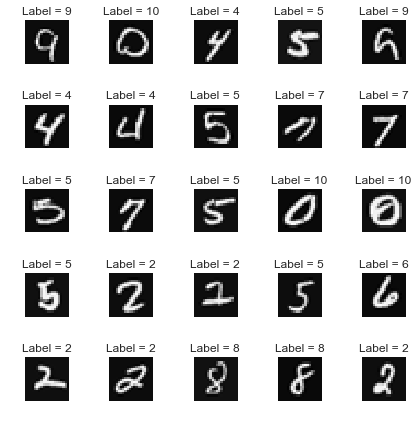

In [3]:
ROW = 5
COLUMN = 5
plt.figure(figsize = [6,6])
for i in range(ROW * COLUMN):
    idx = np.random.randint(0, m)
    image = X[idx ,:].reshape([20,20]).T
    plt.subplot(ROW, COLUMN, i+1)          
    plt.imshow(image, cmap='gray')  
    plt.title("Label = {}".format(y[idx][0]))
    plt.axis('off')  
plt.tight_layout()   
plt.show()

### Combining images into a single row

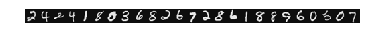

In [4]:
sample = np.random.choice(m, 25)
plt.imshow(X[sample].reshape(-1,20).T, cmap = 'gray')
plt.axis('off')  
plt.show()

### Combining images into a single large array and then displaying 

(-0.5, 99.5, 99.5, -0.5)

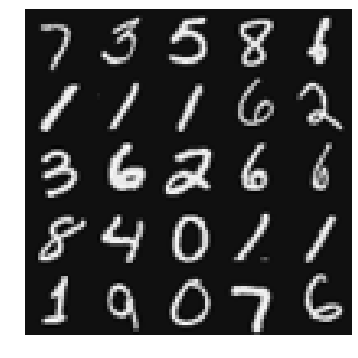

In [5]:
row = 5
column = 5
max_row = row * 20
max_col = column * 20
M = np.zeros((max_row, max_col))
plt.figure(figsize = [6,6])

for i in range(row):
    for j in range(column):
        sample = np.random.choice(m, 1)
        sliceRow, sliceCol = i * 20, j * 20
        M[sliceRow:sliceRow + 20, sliceCol:sliceCol + 20] = X[sample].reshape(-1,20).T
                    
plt.imshow(M, cmap='gray')
plt.axis('off')             
 

# Multiclass Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def costFunctionReg(theta,X,y,lamda):
    '''Compute cost for logistic regression with regularization  '''
    
    #Initializations
    theta = theta[:,np.newaxis]
    m = len(y) 
    J = 0
    
    #Computations
    z = X @ theta
    h = sigmoid(z)
    J_reg = (lamda / (2*m)) * np.sum(np.square(theta[1:]))
    J = (1/m) * ( (-y.T @ np.log(h)) - (1 - y).T @ np.log(1-h)) + J_reg;
    
    if np.isnan(J[0]):
        return(np.inf)
    
    return(J[0])  


def GradientReg(theta,X,y,lamda):
    '''Compute gradient for logistic regression with regularization  '''
    
    #Initializations
    theta = theta[:,np.newaxis]
    m = len(y)
    grad = np.zeros(theta.shape)
    
    #Computations
    z = X @ theta
    h = sigmoid(z)
    grad = (1/m)*(X.T @ ( h - y)) + (lamda/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    
    return(grad.flatten())



### Testing the implementation using dummy data
Note how much more complicated it is to create the dummy X_t array in Numpy... in Matlab the following code is equivalent

    X_t = [ones(5,1) reshape(1:15,5,3)/10]

In [7]:
theta_t = np.array([-2, -1, 1, 2]);
X_t = np.concatenate([np.ones(5)[:,np.newaxis], np.arange(1,16).reshape(3,5).T/10],1)
y_t = np.array([1,0,1,0,1])[:,np.newaxis]
lambda_t = 3;
J = costFunctionReg(theta_t,X_t,y_t,lambda_t)
grad = GradientReg(theta_t,X_t,y_t,lambda_t)

print('\nCost: %f\n', J);
print('Expected cost: 2.534819\n');
print('Gradients:\n');
print(' %f \n', grad);
print('Expected gradients:\n');
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');


Cost: %f
 [2.5348194]
Expected cost: 2.534819

Gradients:

 %f 
 [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:

 0.146561
 -0.548558
 0.724722
 1.398003



## One vs All classification
One-vs-all classification works by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset. In the handwritten digits dataset, $K = 10$.

** Dimensions of the parameter matrix**

The classifier parameters is a matrix $\Theta \in \mathbb{R}^{K \times(N+1)}$ , where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. We can do this with a “for”-loop from 1 to K, training each classifier independently.

Note that the y argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{1,...,K\}$, we will want a $m$-dimensional vector of labels $y$, where $y_j \in \{0,1\}$ indicates whether the $j$-th training instance belongs to class $k (y_j = 1)$, or if it belongs to a different class $(y_j = 0)$.

In [10]:
def OnevsAll(X,y,K,lamda):
    #Initialize variables
    m,n = X.shape
    all_theta = np.zeros((K,n+1))
    initial_theta = np.zeros((n + 1, 1))
    
    #Add column of 1s for y-intercept
    X = np.concatenate([np.ones(m)[:,np.newaxis], X],1)
    
    for k in range(1,K+1):
        model = opt.minimize(fun = costFunctionReg, x0 = initial_theta, args = (X, (y==k)*1, lamda), 
                             method = None, jac = GradientReg, options={'maxiter':100})
        all_theta[k-1] = model.x
    
    return all_theta



In [ ]:
all_theta = OnevsAll(X,y,10,.1)

## One-vs-all Prediction
After training the one-vs-all classifier, we can now use it to predict the digit contained in a given image. For each input, we compute the “probability” that it belongs to each class using the trained logistic regression classifiers. 

The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.

In [ ]:
def predictOneVsAll(all_theta, X): 
    m = X.shape[0]
    num_labels = all_theta.shape[1]
    p = np.zeros((m, 1));
    X = np.concatenate([np.ones(m)[:,np.newaxis], X],1)
    z = X @ all_theta.T
    h = sigmoid(z)
    
    return (np.argmax(h, axis=1)+1)

def Accuracy(y_pred, y):
    return np.mean(y_pred == y.ravel()) 

In [ ]:
y_pred = predictOneVsAll(all_theta, X)
print('Training set accuracy: {} %'.format(np.mean(y_pred == y.ravel())*100))

# Implementation using SKlearn
Of course, training accuracy depends greatly on the regularization value

In [ ]:
model_SK = linear_model.LogisticRegression(C=.1, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
model_SK.fit(X,y.ravel())

In [ ]:
pred2 = model_SK.predict(X)
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel())*100))